## Preprocess the clinical dataset

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.utils import compute_class_weight

The clinical data can be obtained by viewing one's cart on the GDC client, and selecting the "Clinical" download icon. The downloaded folder contains three .tsv files, one of which is "clinical.tsv". First, define the path to our clinical data and where to store our processed dataset.

In [38]:
CLINICAL_DATA_PATH = "/users/anair27/data/anair27/data_original/clinical.tsv"
DESTINATION_DATA_PATH = "/users/anair27/data/TCGA_Data/project_LUAD/data_processed/PRCSD_clinical_data.csv"
DESTINATION_NO_TARGET_DATA_PATH = "/users/anair27/data/TCGA_Data/project_LUAD/data_processed/PRCSD_clinical_data_no_target.csv"

Next, read the data and drop any duplicate cases that may appear.

In [39]:
clinical_data_raw = pd.read_csv(CLINICAL_DATA_PATH, sep = '\t')
clinical_data_raw = clinical_data_raw.drop_duplicates(subset='case_submitter_id', keep="last")

The target variable, **vital_status**, is a binary class. Oftentimes, there is a class imbalance issue. This issue will be addressed using class rebalancing strategies at a later stage in preprocessing, once data modalities have been concatenated.

In [40]:
TARGET_VAR = 'vital_status'

In [41]:
clinical_data_raw[TARGET_VAR].value_counts()

Alive    334
Dead     188
Name: vital_status, dtype: int64

Here are two important variables we are considering. Sometimes, reading the CSVs lead to notation errors for NAs. These should be corrected for.

In [42]:
clinical_data_raw[[TARGET_VAR]]

,vital_status
1,Alive
3,Alive
5,Alive
7,Dead
9,Alive
...,...
1035,Alive
1037,Alive
1039,Dead
1041,Alive


In [43]:
# fill in NAs for extraneous values
clinical_data_nas=clinical_data_raw.mask(clinical_data_raw == '\'--')

Next, we filter out any variables that have missing values.

In [44]:
# filter out columns that have NAs
clinical_data_no_nas = clinical_data_nas.loc[:, ~clinical_data_nas.isnull().any()].reset_index(drop = True)
clinical_data_no_nas.head()

,case_id,case_submitter_id,project_id,ethnicity,gender,race,vital_status,ajcc_pathologic_t,classification_of_tumor,icd_10_code,...,primary_diagnosis,prior_malignancy,prior_treatment,progression_or_recurrence,site_of_resection_or_biopsy,synchronous_malignancy,tissue_or_organ_of_origin,tumor_grade,treatment_or_therapy,treatment_type
0,18478121-f1d1-4bdd-9511-8ab22f4a0660,TCGA-78-8640,TCGA-LUAD,not reported,male,not reported,Alive,T1,not reported,C34.1,...,"Adenocarcinoma, NOS",no,No,not reported,"Upper lobe, lung",No,"Upper lobe, lung",not reported,no,"Radiation Therapy, NOS"
1,9b4eeecb-6aff-435b-a244-ec362af92b7f,TCGA-05-5425,TCGA-LUAD,not reported,male,not reported,Alive,T2b,not reported,C34.9,...,Adenocarcinoma with mixed subtypes,no,No,not reported,"Lung, NOS",No,"Lung, NOS",not reported,yes,"Pharmaceutical Therapy, NOS"
2,dd46c83e-6551-485b-b935-f3beed891244,TCGA-55-7815,TCGA-LUAD,not reported,male,not reported,Alive,T2a,not reported,C34.3,...,"Adenocarcinoma, NOS",no,No,not reported,"Lower lobe, lung",No,"Lower lobe, lung",not reported,yes,"Pharmaceutical Therapy, NOS"
3,cbfef004-b437-4d51-9d88-a2db50aa6481,TCGA-44-7661,TCGA-LUAD,not hispanic or latino,female,white,Dead,T2a,not reported,C34.3,...,"Adenocarcinoma, NOS",yes,No,not reported,"Lower lobe, lung",Not Reported,"Lower lobe, lung",not reported,yes,"Radiation Therapy, NOS"
4,a9644274-13bb-4228-9b4f-14260ccc26eb,TCGA-97-7554,TCGA-LUAD,not hispanic or latino,female,white,Alive,T2a,not reported,C34.3,...,"Papillary adenocarcinoma, NOS",no,No,not reported,"Lower lobe, lung",No,"Lower lobe, lung",not reported,yes,"Pharmaceutical Therapy, NOS"


There are still several features that have very little variation (same labels across most cases). We can determine coefficients of variation for the categorical features to determine ones that may be more informative for analysis.

<BarContainer object of 22 artists>

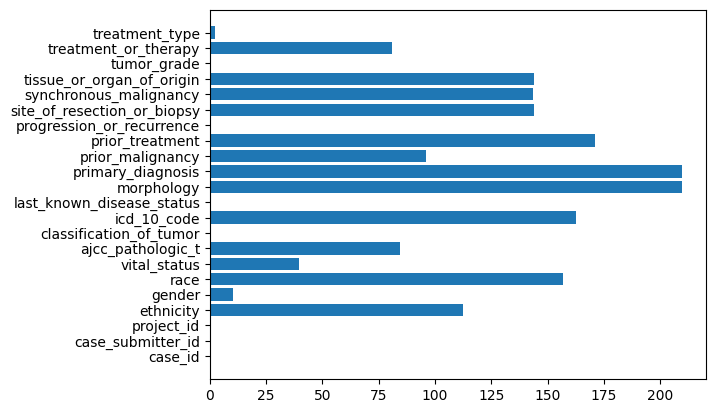

In [45]:
cvs = {}
for column in clinical_data_no_nas.columns:
    if clinical_data_no_nas[column].dtype == 'object':
        frequencies = clinical_data_no_nas[column].value_counts()
        std_dev = frequencies.std()
        mean = frequencies.mean()
        CV = (std_dev / mean) * 100
        cvs[column] = CV
plt.barh(range(len(cvs)), list(cvs.values()), tick_label=list(cvs.keys()))

We can determine a specific threshold (here it is 70) to isolate highly variable features.

In [46]:
hv_features = []
for var in cvs:
    if cvs[var] > 70:
        hv_features.append(var)
print(hv_features)

['ethnicity', 'race', 'ajcc_pathologic_t', 'icd_10_code', 'morphology', 'primary_diagnosis', 'prior_malignancy', 'prior_treatment', 'site_of_resection_or_biopsy', 'synchronous_malignancy', 'tissue_or_organ_of_origin', 'treatment_or_therapy']


Next, we convert the categorical variables into dummy variables to represent them numerically.

In [47]:
categorical = [TARGET_VAR] + hv_features

In [48]:
dfs = []
for col in categorical:
    dfs.append(pd.get_dummies(clinical_data_no_nas[col], prefix = col, drop_first = True))
categorical_dummies = pd.concat(dfs, axis = 1)
categorical_dummies

,vital_status_Dead,ethnicity_not hispanic or latino,ethnicity_not reported,race_asian,race_black or african american,race_not reported,race_white,ajcc_pathologic_t_T1a,ajcc_pathologic_t_T1b,ajcc_pathologic_t_T2,...,"site_of_resection_or_biopsy_Upper lobe, lung",synchronous_malignancy_Not Reported,synchronous_malignancy_Yes,"tissue_or_organ_of_origin_Lung, NOS",tissue_or_organ_of_origin_Main bronchus,"tissue_or_organ_of_origin_Middle lobe, lung",tissue_or_organ_of_origin_Overlapping lesion of lung,"tissue_or_organ_of_origin_Upper lobe, lung",treatment_or_therapy_not reported,treatment_or_therapy_yes
0,0,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1,0,0,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,0,0,1,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,1,0,1
518,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,1
519,1,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
520,0,1,0,0,0,0,1,0,1,0,...,1,0,0,0,0,0,0,1,0,0


In [49]:
# Attach the case ID as a feature
c_data = categorical_dummies.assign(case_id=clinical_data_no_nas["case_submitter_id"])
c_data.head()

,vital_status_Dead,ethnicity_not hispanic or latino,ethnicity_not reported,race_asian,race_black or african american,race_not reported,race_white,ajcc_pathologic_t_T1a,ajcc_pathologic_t_T1b,ajcc_pathologic_t_T2,...,synchronous_malignancy_Not Reported,synchronous_malignancy_Yes,"tissue_or_organ_of_origin_Lung, NOS",tissue_or_organ_of_origin_Main bronchus,"tissue_or_organ_of_origin_Middle lobe, lung",tissue_or_organ_of_origin_Overlapping lesion of lung,"tissue_or_organ_of_origin_Upper lobe, lung",treatment_or_therapy_not reported,treatment_or_therapy_yes,case_id
0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,TCGA-78-8640
1,0,0,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,TCGA-05-5425
2,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,TCGA-55-7815
3,1,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,TCGA-44-7661
4,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,TCGA-97-7554


Save the processed clinical data!

In [50]:
c_data.to_csv(DESTINATION_DATA_PATH)

In [51]:
clinical_data = c_data.loc[:, c_data.columns != 'vital_status_Dead']
clinical_data.to_csv(DESTINATION_NO_TARGET_DATA_PATH)

---

EXPERIMENTAL: Trying AJCC pathology target variable. (4/3)

In [111]:
CLINICAL_DATA_PATH = "/users/anair27/data/anair27/data_original/clinical.tsv"
DESTINATION_DATA_PATH = "/users/anair27/data/TCGA_Data/project_LUAD/data_processed/PRCSD_clinical_data_AJCC.csv"
DESTINATION_NO_TARGET_DATA_PATH = "/users/anair27/data/TCGA_Data/project_LUAD/data_processed/PRCSD_clinical_data_no_target_AJCC.csv"

In [112]:
clinical_data_raw = pd.read_csv(CLINICAL_DATA_PATH, sep = '\t')
clinical_data_raw = clinical_data_raw.drop_duplicates(subset='case_submitter_id', keep="last")

In [113]:
TARGET_VAR = 'ajcc_pathologic_t'

In [114]:
clinical_data_raw[TARGET_VAR].value_counts()

T2     171
T2a     82
T1      69
T1b     55
T1a     48
T3      47
T2b     28
T4      19
TX       3
Name: ajcc_pathologic_t, dtype: int64

In [115]:
list(clinical_data_raw.columns)

['case_id',
 'case_submitter_id',
 'project_id',
 'age_at_index',
 'age_is_obfuscated',
 'cause_of_death',
 'cause_of_death_source',
 'country_of_residence_at_enrollment',
 'days_to_birth',
 'days_to_death',
 'ethnicity',
 'gender',
 'occupation_duration_years',
 'premature_at_birth',
 'race',
 'vital_status',
 'weeks_gestation_at_birth',
 'year_of_birth',
 'year_of_death',
 'adrenal_hormone',
 'age_at_diagnosis',
 'ajcc_clinical_m',
 'ajcc_clinical_n',
 'ajcc_clinical_stage',
 'ajcc_clinical_t',
 'ajcc_pathologic_m',
 'ajcc_pathologic_n',
 'ajcc_pathologic_stage',
 'ajcc_pathologic_t',
 'ajcc_staging_system_edition',
 'anaplasia_present',
 'anaplasia_present_type',
 'ann_arbor_b_symptoms',
 'ann_arbor_b_symptoms_described',
 'ann_arbor_clinical_stage',
 'ann_arbor_extranodal_involvement',
 'ann_arbor_pathologic_stage',
 'best_overall_response',
 'breslow_thickness',
 'burkitt_lymphoma_clinical_variant',
 'child_pugh_classification',
 'circumferential_resection_margin',
 'classificatio

In [116]:
df

,age_at_index,ajcc_pathologic_t
1,59,T1
3,68,T2b
5,76,T2a
7,69,T2a
9,83,T2a
...,...,...
1035,66,T2
1037,58,T1
1039,75,T3
1041,70,T1b


In [117]:
df = clinical_data_raw[['age_at_index', TARGET_VAR]]
df.replace('\'--', np.nan, inplace=True)
df = df.dropna()
df

/tmp/ipykernel_223535/1281017668.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace('\'--', np.nan, inplace=True)


,age_at_index,ajcc_pathologic_t
1,59,T1
3,68,T2b
5,76,T2a
7,69,T2a
9,83,T2a
...,...,...
1035,66,T2
1037,58,T1
1039,75,T3
1041,70,T1b


In [118]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Embedding, Flatten
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [168]:
# Encode variable ajcc_pathologic_t using LabelEncoder
le_ajcc_pathologic_t = LabelEncoder()
df['ajcc_pathologic_t_encoded'] = le_ajcc_pathologic_t.fit_transform(df['ajcc_pathologic_t'])
num_classes_t = len(le_ajcc_pathologic_t.classes_)

train, test = train_test_split(df)

In [169]:
m = tf.keras.models.Sequential()
x_train = train['age_at_index'].astype('int').to_numpy()
x_test = test['age_at_index'].astype('int').to_numpy()
y_train = train['ajcc_pathologic_t_encoded']
y_test = test['ajcc_pathologic_t_encoded']

In [170]:
x_train

array([70, 53, 64, 76, 79, 41, 49, 60, 69, 68, 70, 69, 77, 64, 63, 57, 68,
       76, 62, 76, 73, 72, 81, 67, 72, 54, 65, 70, 87, 59, 79, 77, 70, 78,
       76, 63, 74, 76, 71, 55, 49, 73, 52, 45, 68, 54, 76, 56, 52, 82, 59,
       62, 64, 69, 60, 67, 57, 52, 72, 81, 69, 55, 59, 85, 81, 58, 64, 54,
       53, 70, 54, 77, 54, 79, 58, 63, 55, 75, 50, 59, 59, 64, 76, 72, 48,
       74, 54, 60, 75, 58, 57, 67, 65, 57, 76, 52, 62, 67, 71, 71, 42, 57,
       74, 63, 60, 86, 41, 58, 75, 74, 66, 77, 63, 64, 61, 71, 40, 80, 45,
       68, 65, 75, 66, 65, 75, 58, 69, 61, 65, 67, 67, 76, 57, 79, 76, 76,
       47, 60, 61, 62, 68, 81, 70, 58, 50, 75, 38, 74, 75, 72, 84, 77, 73,
       72, 63, 51, 67, 67, 52, 67, 52, 52, 59, 71, 61, 69, 61, 69, 61, 76,
       78, 53, 77, 65, 70, 50, 77, 72, 81, 66, 63, 46, 73, 39, 78, 66, 60,
       76, 72, 45, 42, 81, 58, 66, 62, 84, 69, 70, 52, 60, 64, 58, 73, 49,
       68, 65, 70, 54, 63, 65, 56, 74, 66, 63, 61, 57, 59, 70, 72, 41, 69,
       69, 62, 78, 41, 66

In [171]:
num_classes_t

9

In [172]:
inp = Input(shape=(1,), name='input')
hidden = Dense(32, activation='relu')(inp)
output = Dense(num_classes_t, activation='softmax')(hidden)

In [173]:
m = Model(inputs=inp, outputs=output )

In [174]:
m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [175]:
from sklearn.utils import compute_class_weight
weights = compute_class_weight('balanced', classes=list(range(9)), y=list(y_train))
    

In [176]:
class_weights = {}
for i, w in enumerate(weights):
    class_weights[i] = w
class_weights

{0: 0.9741602067183462,
 1: 0.952020202020202,
 2: 0.9973544973544973,
 3: 0.37069813176007865,
 4: 0.6756272401433692,
 5: 2.3271604938271606,
 6: 1.132132132132132,
 7: 2.6180555555555554,
 8: 20.944444444444443}

In [177]:
train[TARGET_VAR].value_counts()

T2     113
T2a     62
T1a     44
T1      43
T1b     42
T3      37
T2b     18
T4      16
TX       2
Name: ajcc_pathologic_t, dtype: int64

In [179]:
m.fit(x_train, tf.keras.utils.to_categorical(y_train), epochs = 100, class_weight=class_weights)

Epoch 1/100
12/12 [==============================] - 0s 2ms/step - loss: 2.2397 - accuracy: 0.1167
Epoch 2/100
12/12 [==============================] - 0s 2ms/step - loss: 2.2150 - accuracy: 0.0690
Epoch 3/100
12/12 [==============================] - 0s 2ms/step - loss: 2.2285 - accuracy: 0.0398
Epoch 4/100
12/12 [==============================] - 0s 2ms/step - loss: 2.2772 - accuracy: 0.1379
Epoch 5/100
12/12 [==============================] - 0s 2ms/step - loss: 2.2193 - accuracy: 0.0902
Epoch 6/100
12/12 [==============================] - 0s 2ms/step - loss: 2.2219 - accuracy: 0.0212
Epoch 7/100
12/12 [==============================] - 0s 2ms/step - loss: 2.2169 - accuracy: 0.0265
Epoch 8/100
12/12 [==============================] - 0s 2ms/step - loss: 2.2322 - accuracy: 0.1008
Epoch 9/100
12/12 [==============================] - 0s 2ms/step - loss: 2.2411 - accuracy: 0.2069
Epoch 10/100
12/12 [==============================] - 0s 2ms/step - loss: 2.2178 - accuracy: 0.0477
Epoch 11/

12/12 [==============================] - 0s 2ms/step - loss: 2.2460 - accuracy: 0.0451
Epoch 84/100
12/12 [==============================] - 0s 2ms/step - loss: 2.2100 - accuracy: 0.1936
Epoch 85/100
12/12 [==============================] - 0s 2ms/step - loss: 2.2408 - accuracy: 0.1300
Epoch 86/100
12/12 [==============================] - 0s 2ms/step - loss: 2.2098 - accuracy: 0.1034
Epoch 87/100
12/12 [==============================] - 0s 2ms/step - loss: 2.2436 - accuracy: 0.0398
Epoch 88/100
12/12 [==============================] - 0s 2ms/step - loss: 2.2475 - accuracy: 0.1432
Epoch 89/100
12/12 [==============================] - 0s 2ms/step - loss: 2.2161 - accuracy: 0.0822
Epoch 90/100
12/12 [==============================] - 0s 2ms/step - loss: 2.2159 - accuracy: 0.0690
Epoch 91/100
12/12 [==============================] - 0s 2ms/step - loss: 2.2232 - accuracy: 0.0610
Epoch 92/100
12/12 [==============================] - 0s 2ms/step - loss: 2.2298 - accuracy: 0.1751
Epoch 93/100


In [183]:
pd.DataFrame(m.predict(x_test))

4/4 [==============================] - 0s 2ms/step


,0,1,2,3,4,5,6,7,8
0,0.103745,0.112985,0.136431,0.115679,0.109109,0.117450,0.146174,0.109685,0.048741
1,0.104570,0.111957,0.138682,0.115555,0.108986,0.117652,0.148591,0.108661,0.045347
2,0.104367,0.112217,0.138120,0.115590,0.109020,0.117605,0.147987,0.108920,0.046174
3,0.099148,0.117599,0.125001,0.115638,0.109102,0.115785,0.133903,0.114299,0.069525
4,0.103106,0.113737,0.134736,0.115745,0.109176,0.117272,0.144354,0.110434,0.051440
...,...,...,...,...,...,...,...,...,...
121,0.098127,0.118392,0.122675,0.115482,0.108961,0.115308,0.131408,0.115098,0.074549
122,0.103106,0.113737,0.134736,0.115745,0.109176,0.117272,0.144354,0.110434,0.051440
123,0.103745,0.112985,0.136431,0.115679,0.109109,0.117450,0.146174,0.109685,0.048741
124,0.101084,0.115872,0.129611,0.115795,0.109238,0.116590,0.138852,0.112568,0.060391


In [57]:
# fill in NAs for extraneous values
clinical_data_nas=clinical_data_raw.mask(clinical_data_raw == '\'--')

In [58]:
# filter out columns that have NAs
clinical_data_no_nas = clinical_data_nas.loc[:, ~clinical_data_nas.isnull().any()].reset_index(drop = True)
clinical_data_no_nas.head()

,case_id,case_submitter_id,project_id,ethnicity,gender,race,vital_status,ajcc_pathologic_t,classification_of_tumor,icd_10_code,...,primary_diagnosis,prior_malignancy,prior_treatment,progression_or_recurrence,site_of_resection_or_biopsy,synchronous_malignancy,tissue_or_organ_of_origin,tumor_grade,treatment_or_therapy,treatment_type
0,18478121-f1d1-4bdd-9511-8ab22f4a0660,TCGA-78-8640,TCGA-LUAD,not reported,male,not reported,Alive,T1,not reported,C34.1,...,"Adenocarcinoma, NOS",no,No,not reported,"Upper lobe, lung",No,"Upper lobe, lung",not reported,no,"Radiation Therapy, NOS"
1,9b4eeecb-6aff-435b-a244-ec362af92b7f,TCGA-05-5425,TCGA-LUAD,not reported,male,not reported,Alive,T2b,not reported,C34.9,...,Adenocarcinoma with mixed subtypes,no,No,not reported,"Lung, NOS",No,"Lung, NOS",not reported,yes,"Pharmaceutical Therapy, NOS"
2,dd46c83e-6551-485b-b935-f3beed891244,TCGA-55-7815,TCGA-LUAD,not reported,male,not reported,Alive,T2a,not reported,C34.3,...,"Adenocarcinoma, NOS",no,No,not reported,"Lower lobe, lung",No,"Lower lobe, lung",not reported,yes,"Pharmaceutical Therapy, NOS"
3,cbfef004-b437-4d51-9d88-a2db50aa6481,TCGA-44-7661,TCGA-LUAD,not hispanic or latino,female,white,Dead,T2a,not reported,C34.3,...,"Adenocarcinoma, NOS",yes,No,not reported,"Lower lobe, lung",Not Reported,"Lower lobe, lung",not reported,yes,"Radiation Therapy, NOS"
4,a9644274-13bb-4228-9b4f-14260ccc26eb,TCGA-97-7554,TCGA-LUAD,not hispanic or latino,female,white,Alive,T2a,not reported,C34.3,...,"Papillary adenocarcinoma, NOS",no,No,not reported,"Lower lobe, lung",No,"Lower lobe, lung",not reported,yes,"Pharmaceutical Therapy, NOS"


<BarContainer object of 22 artists>

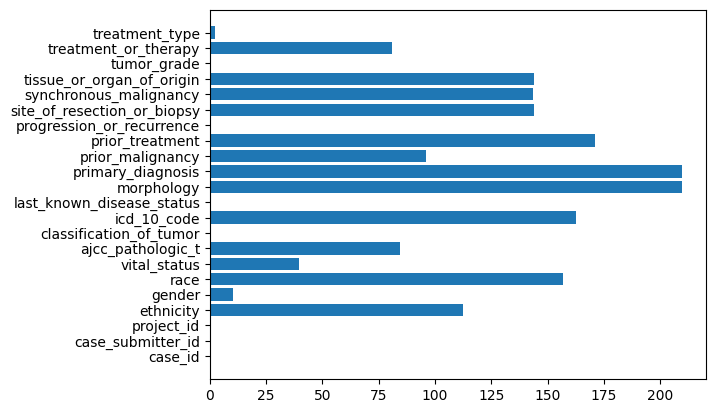

In [59]:
cvs = {}
for column in clinical_data_no_nas.columns:
    if clinical_data_no_nas[column].dtype == 'object':
        frequencies = clinical_data_no_nas[column].value_counts()
        std_dev = frequencies.std()
        mean = frequencies.mean()
        CV = (std_dev / mean) * 100
        cvs[column] = CV
plt.barh(range(len(cvs)), list(cvs.values()), tick_label=list(cvs.keys()))

In [60]:
hv_features = []
for var in cvs:
    if cvs[var] > 70:
        hv_features.append(var)
print(hv_features)

['ethnicity', 'race', 'ajcc_pathologic_t', 'icd_10_code', 'morphology', 'primary_diagnosis', 'prior_malignancy', 'prior_treatment', 'site_of_resection_or_biopsy', 'synchronous_malignancy', 'tissue_or_organ_of_origin', 'treatment_or_therapy']


In [62]:
categorical = hv_features

In [64]:
dfs = []
for col in categorical:
    dfs.append(pd.get_dummies(clinical_data_no_nas[col], prefix = col, drop_first = True))
categorical_dummies = pd.concat(dfs, axis = 1)
categorical_dummies

,ethnicity_not hispanic or latino,ethnicity_not reported,race_asian,race_black or african american,race_not reported,race_white,ajcc_pathologic_t_T1a,ajcc_pathologic_t_T1b,ajcc_pathologic_t_T2,ajcc_pathologic_t_T2a,...,"site_of_resection_or_biopsy_Upper lobe, lung",synchronous_malignancy_Not Reported,synchronous_malignancy_Yes,"tissue_or_organ_of_origin_Lung, NOS",tissue_or_organ_of_origin_Main bronchus,"tissue_or_organ_of_origin_Middle lobe, lung",tissue_or_organ_of_origin_Overlapping lesion of lung,"tissue_or_organ_of_origin_Upper lobe, lung",treatment_or_therapy_not reported,treatment_or_therapy_yes
0,0,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
4,1,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,0,1,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,1
518,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
519,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
520,1,0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0


In [65]:
# Attach the case ID as a feature
c_data = categorical_dummies.assign(case_id=clinical_data_no_nas["case_submitter_id"])
c_data.head()

,ethnicity_not hispanic or latino,ethnicity_not reported,race_asian,race_black or african american,race_not reported,race_white,ajcc_pathologic_t_T1a,ajcc_pathologic_t_T1b,ajcc_pathologic_t_T2,ajcc_pathologic_t_T2a,...,synchronous_malignancy_Not Reported,synchronous_malignancy_Yes,"tissue_or_organ_of_origin_Lung, NOS",tissue_or_organ_of_origin_Main bronchus,"tissue_or_organ_of_origin_Middle lobe, lung",tissue_or_organ_of_origin_Overlapping lesion of lung,"tissue_or_organ_of_origin_Upper lobe, lung",treatment_or_therapy_not reported,treatment_or_therapy_yes,case_id
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,TCGA-78-8640
1,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,TCGA-05-5425
2,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,TCGA-55-7815
3,1,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,1,TCGA-44-7661
4,1,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,TCGA-97-7554
